In [40]:
import kan
import kan.utils as ku
import numpy as np
import torch.nn as nn
import torch
import qutip as qt
import matplotlib.pyplot as plt
import itertools
from libraries import utils
from libraries import magnetization
from libraries import j1j2_functions

In [41]:
N=12; J1=1
J2s = np.linspace(0, 0.5 - 0.5/100, 100)
print(J2s[-1])
gss = [qt.qload(f'../J1J2_info/N{N}/n{N}gs_J2_{round(J2, 3)}') for J2 in J2s]
states = utils.get_nonzero_states(N, gss[0], 1e-10)[0]
signs = [utils.get_nonzero_states(N, gs, 1e-10)[1] for gs in gss]

nd = 0b010101010101 # this never deviates, let this be of negative sign cos(pi/4 * amplitude)
# nd = 0b01010101
index = states.index(nd)
print(nd)
for i in range(len(signs)):
    if signs[i][index] > 0:
        signs[i] = -1 * np.array(signs[i])
    else:
        signs[i] = np.array(signs[i])

devs = [(signs[0] != signs[i]).astype(float) for i in range(len(signs))]

def rfft(x):
    x = (-1) ** np.array(x)
    return np.fft.rfft(x)[1:]

input = utils.generate_input_samples(N, states)
print(input.shape)
ft_input = []
for x in input:
    amp_phase = []
    ft = rfft(x)
    for c in ft:
        amp_phase.append(np.abs(c))
        amp_phase.append(np.angle(c) % (2 * np.pi))
    ft_input.append(amp_phase)
ft_input = torch.tensor(ft_input)

0.495
1365
torch.Size([924, 12])


C:\Users\taoha\AppData\Local\Temp\ipykernel_16688\1270331291.py:21: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  x = (-1) ** np.array(x)


In [16]:
amp_input = ft_input[:, ::2]
#cub_amp = torch.hstack((amp_input, amp_input ** 2, amp_input ** 3))

# cub_amp_j2 = torch.vstack((cub_amp,) * len(J2s))
amp_j2 = torch.vstack((amp_input,) * len(J2s))
j2_data = torch.vstack(tuple(torch.tensor([j2] * amp_input.shape[0], dtype=torch.float32).reshape(-1, 1) for j2 in J2s))
j2_devs = torch.vstack(tuple(torch.tensor(devs[i], dtype=torch.float32).reshape(-1, 1) for i in range(len(devs))))
j2_signs = torch.vstack(tuple(torch.tensor(signs[i], dtype=torch.float32).reshape(-1, 1) for i in range(len(signs))))
print(amp_j2.shape, j2_data.shape, j2_signs.shape)
print(amp_j2.dtype, j2_data.dtype, j2_signs.dtype)

torch.Size([92400, 6]) torch.Size([92400, 1]) torch.Size([92400, 1])
torch.float32 torch.float32 torch.float32


In [17]:
all_data = torch.hstack((amp_j2, j2_data))
print(all_data.shape)
dataset = {'train_input':all_data, 'train_label':j2_signs, 'test_input':all_data, 'test_label':j2_signs}

torch.Size([92400, 7])


In [21]:
kan_j2 = kan.KAN(width=[7, 7, 7, 1])
kan_j2.fit(dataset, lamb=0, steps=20);

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.05e-01 | test_loss: 3.05e-01 | reg: 7.14e+01 | : 100%|█| 20/20 [05:23<00:00, 16.19s/

saving model version 0.1


In [22]:
kan_j2.prune().width

saving model version 0.2


[[7, 0], [7, 0], [7, 0], [1, 0]]

In [26]:
torch.sqrt(((kan_j2(all_data) - j2_signs) ** 2).mean())

tensor(0.3051, grad_fn=<SqrtBackward0>)

In [27]:
torch.sqrt(((kan_j2(all_data).round() - j2_signs) ** 2).mean())

tensor(0.3241, grad_fn=<SqrtBackward0>)

In [23]:
kan_j2(all_data)

tensor([[ 0.6384],
        [-1.0808],
        [ 0.7464],
        ...,
        [ 0.6586],
        [-1.4204],
        [ 0.3464]], grad_fn=<AddBackward0>)

In [25]:
kan_j2(all_data).round()

tensor([[ 1.],
        [-1.],
        [ 1.],
        ...,
        [ 1.],
        [-1.],
        [ 0.]], grad_fn=<RoundBackward0>)

In [28]:
dataset_dev = {'train_input':all_data, 'train_label':j2_devs, 'test_input':all_data, 'test_label':j2_devs}

In [29]:
kan_dev = kan.KAN(width=[7, 7, 7, 1])
kan_dev.fit(dataset_dev, lamb=0, steps=20);

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.17e-01 | test_loss: 1.17e-01 | reg: 5.24e+01 | : 100%|█| 20/20 [05:19<00:00, 15.97s/

saving model version 0.1


In [32]:
torch.sqrt(((kan_dev(all_data).round() - j2_devs) ** 2).mean())

tensor(0.0947, grad_fn=<SqrtBackward0>)

In [33]:
kan_dev.prune().width

saving model version 0.2


[[7, 0], [7, 0], [7, 0], [1, 0]]

In [35]:
j1j2_functions.J1J2_hamiltonian(6, 1, 0).eigenstates()[0][:5]

array([-11.21110255,  -8.47213595,  -8.47213595,  -8.47213595,
        -6.        ])

In [36]:
j1j2_functions.J1J2_hamiltonian(8, 1, 0).eigenstates()[0][:5]

array([-14.60437364, -12.51367626, -12.51367626, -12.51367626,
       -10.79851259])

In [37]:
j1j2_functions.J1J2_hamiltonian(10, 1, 0).eigenstates()[0][:5]

array([-18.06178542, -16.36882939, -16.36882939, -16.36882939,
       -15.08238974])

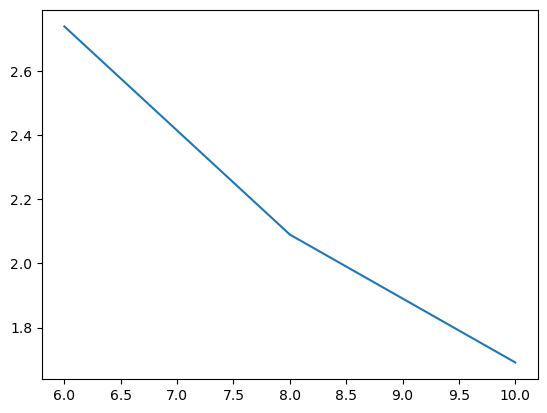

In [39]:
plt.plot([6, 8, 10], [11.211-8.472, 14.604-12.514, 18.06-16.369])
plt.show()